In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

calls = pd.read_csv('/kaggle/input/skyhack/calls.csv')
customers = pd.read_csv('/kaggle/input/skyhack/customers.csv')
reason = pd.read_csv('/kaggle/input/skyhack/reason.csv')
sentiment_statistics = pd.read_csv('/kaggle/input/skyhack/sentiment_statistics.csv')
test = pd.read_csv('/kaggle/input/skyhack/test.csv')

In [2]:
test.head()

,call_id
0,7732610078
1,2400299738
2,6533095063
3,7774450920
4,9214147168


# Data Processing: Primary Call Reasons

To enhance data consistency and improve analysis accuracy, we cleaned the primary_call_reason dataset. This involved:
Standardization: We converted all entries to lowercase to eliminate case sensitivity.

Trimming Whitespace: Leading and trailing spaces were removed from each entry to ensure uniformity.
Normalization: Variations in terminology were unified (e.g., "Voluntary Cancel" and "voluntary cancel" were consolidated).

Reduction of Duplicates: Similar categories were merged to avoid redundancy (e.g., "Traveler Updates" variations).



In [3]:
reason["primary_call_reason"].unique()

array(['Voluntary  Cancel', 'Booking', 'IRROPS', 'Upgrade', 'Seating',
       'Mileage   Plus', 'Checkout', 'Voluntary   Change', 'Post Flight',
       'Check In', 'Other  Topics', 'Communications', 'Schedule Change',
       'Products & Services', 'IRROPS  ', 'Digital   Support',
       'Seating  ', 'Disability', 'Unaccompanied Minor', ' Baggage',
       'Traveler  Updates', 'Communications  ', 'ETC', 'Upgrade  ',
       'Unaccompanied Minor  ', 'Voluntary Change', 'Voluntary Change  ',
       'Checkout  ', 'Mileage Plus', 'Mileage Plus  ', 'Booking  ',
       'Baggage  ', 'Post-Flight', 'Post-Flight  ', 'Schedule Change  ',
       'Baggage', 'Traveler Updates', 'Voluntary Cancel', 'Check-In',
       'Products and Services', 'Check-In  ', 'Other Topics',
       'Other Topics  ', 'ETC  ', 'Disability  ', 'Digital Support',
       'Digital Support  ', 'Voluntary Cancel  ',
       'Products and Services  ', 'Traveler Updates  ',
       'Traveler   Updates', 'Digital  Support', 'Mileage  P

In [4]:
# Create a mapping dictionary for standardization
standardization_mapping = {
    'voluntary  cancel': 'voluntary cancel',
    'booking': 'booking',
    'irrops': 'irrops',
    'upgrade': 'upgrade',
    'seating': 'seating',
    'mileage   plus': 'mileage plus',
    'checkout': 'checkout',
    'voluntary   change': 'voluntary change',
    'post flight': 'post-flight',
    'check in': 'check-in',
    'other  topics': 'other topics',
    'communications': 'communications',
    'schedule change': 'schedule change',
    'products & services': 'products and services',
    'digital   support': 'digital support',
    'disability': 'disability',
    'unaccompanied minor': 'unaccompanied minor',
    'baggage': 'baggage',
    'traveler  updates': 'traveler updates',
    'etc': 'etc',
}

# Normalize the primary_call_reason by stripping spaces and lowercasing
reason['primary_call_reason'] = reason['primary_call_reason'].str.strip().str.lower()

# Apply the mapping to standardize the call reasons
reason['primary_call_reason'] = reason['primary_call_reason'].replace(standardization_mapping)

# Now, check the unique values in the updated DataFrame
unique_reasons = reason['primary_call_reason'].unique()

print(unique_reasons)

['voluntary cancel' 'booking' 'irrops' 'upgrade' 'seating' 'mileage plus'
 'checkout' 'voluntary change' 'post-flight' 'check-in' 'other topics'
 'communications' 'schedule change' 'products and services'
 'digital support' 'disability' 'unaccompanied minor' 'baggage'
 'traveler updates' 'etc' 'traveler   updates' 'digital  support'
 'mileage  plus' 'voluntary  change']


In [5]:
# Create a mapping dictionary for standardization
standardization_mapping = {
    'voluntary cancel': 'voluntary cancel',
    'booking': 'booking',
    'irrops': 'irrops',
    'upgrade': 'upgrade',
    'seating': 'seating',
    'mileage plus': 'mileage plus',
    'checkout': 'checkout',
    'voluntary change': 'voluntary change',
    'post-flight': 'post-flight',
    'check-in': 'check-in',
    'other topics': 'other topics',
    'communications': 'communications',
    'schedule change': 'schedule change',
    'products and services': 'products and services',
    'digital support': 'digital support',
    'disability': 'disability',
    'unaccompanied minor': 'unaccompanied minor',
    'baggage': 'baggage',
    'traveler updates': 'traveler updates',
    'etc': 'etc',
}

# Normalize the primary_call_reason by removing extra spaces and lowercasing
reason['primary_call_reason'] = reason['primary_call_reason'].str.strip().str.lower()

# Handle extra spaces
reason['primary_call_reason'] = reason['primary_call_reason'].apply(lambda x: re.sub(r'\s+', ' ', x))

# Apply the mapping to standardize the call reasons
reason['primary_call_reason'] = reason['primary_call_reason'].replace(standardization_mapping)

# Now, check the unique values in the updated DataFrame
unique_reasons = reason['primary_call_reason'].unique()

print(unique_reasons)

['voluntary cancel' 'booking' 'irrops' 'upgrade' 'seating' 'mileage plus'
 'checkout' 'voluntary change' 'post-flight' 'check-in' 'other topics'
 'communications' 'schedule change' 'products and services'
 'digital support' 'disability' 'unaccompanied minor' 'baggage'
 'traveler updates' 'etc']


# Primary Call Reasons by PERCENTAGE causing increase in Average Handling Time

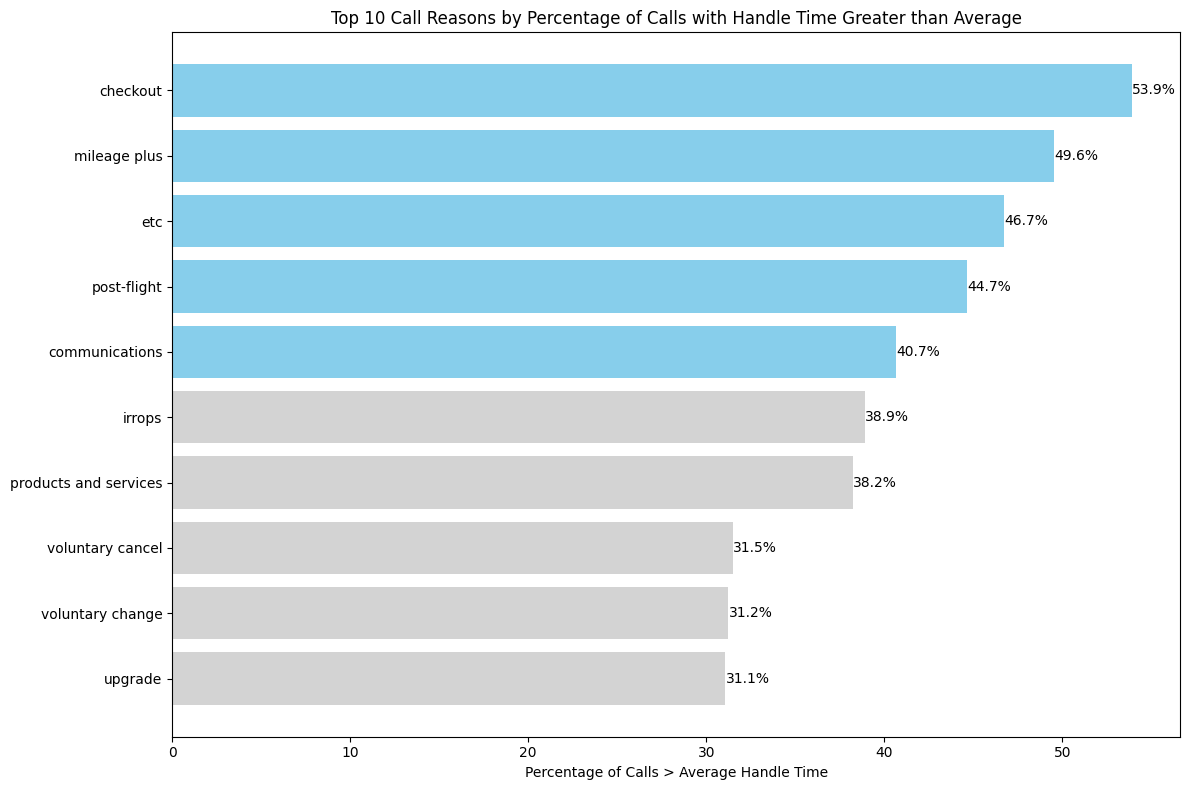

In [6]:
# Converting datetime columns to proper datetime format
calls['agent_assigned_datetime'] = pd.to_datetime(calls['agent_assigned_datetime'])
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'])

# Calculating handle time in minutes
calls['handle_time'] = (calls['call_end_datetime'] - calls['agent_assigned_datetime']).dt.total_seconds() / 60

# Average handle time
average_handle_time = calls['handle_time'].mean()

# Merging reason_df with calls_df to associate call reasons with handle times
merged_df = pd.merge(calls, reason, on='call_id')

# Standardize the primary_call_reason to remove duplicates caused by case differences, whitespace, etc.
merged_df['primary_call_reason'] = merged_df['primary_call_reason'].str.strip().str.lower()

# Ensure we only use unique primary call reasons
merged_df = merged_df.drop_duplicates(subset=['call_id', 'primary_call_reason'])

# Adding a column indicating whether handle time is greater than the average handle time
merged_df['greater_than_average'] = merged_df['handle_time'] > average_handle_time

# Grouping by primary call reason to calculate the percentage of calls with handle_time greater than average for each reason
reason_stats = merged_df.groupby('primary_call_reason')['greater_than_average'].mean() * 100

# Sorting the reason_stats by values to order the bars
reason_stats_sorted = reason_stats.sort_values(ascending=False)

# Sorting by values to get top 10 and highlighting top 5
reason_stats_top10 = reason_stats_sorted.sort_values(ascending=False).head(10)
top_5_reasons = reason_stats_top10.head(5)

# Plotting a horizontal bar chart and highlighting top 5
plt.figure(figsize=(12, 8))
bars = plt.barh(reason_stats_top10.index, reason_stats_top10.values, color='lightgray')
plt.barh(top_5_reasons.index, top_5_reasons.values, color='skyblue')  # Highlighting top 5 in a different color

plt.xlabel('Percentage of Calls > Average Handle Time')
plt.title('Top 10 Call Reasons by Percentage of Calls with Handle Time Greater than Average')
plt.gca().invert_yaxis()  # To have the highest value at the top

# Adding data labels to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1f}%', va='center')

plt.tight_layout()
plt.show()


# Average Call Duration By Primary Call Duration

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


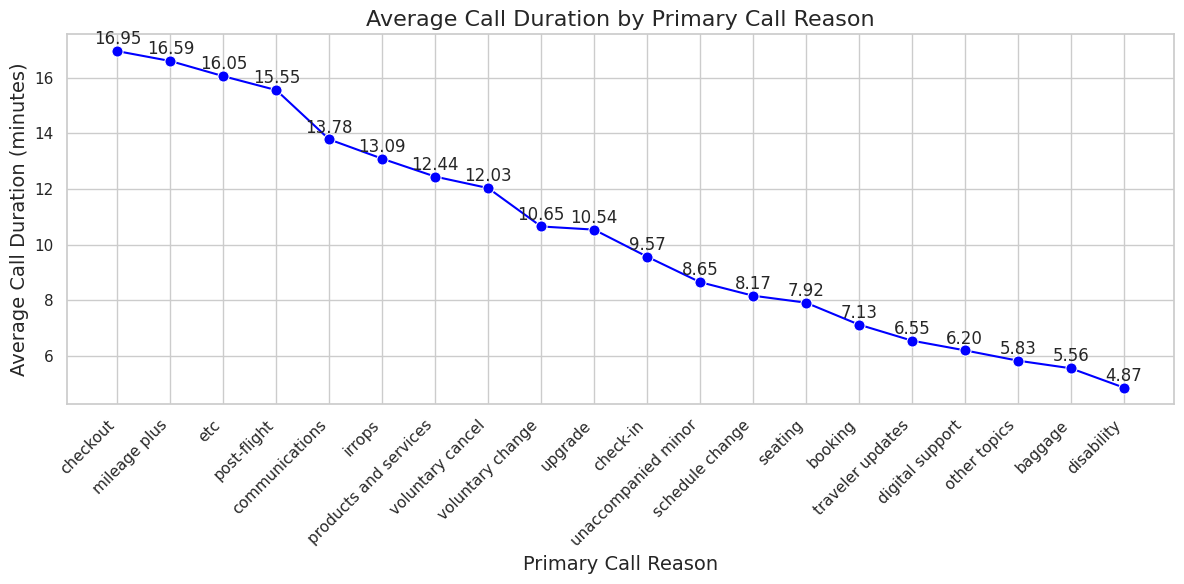

In [21]:
# Assuming merged_df is your DataFrame containing the call data with handle_time and primary_call_reason
# Calculate average handle time for each primary call reason
average_call_duration = merged_df.groupby('primary_call_reason')['handle_time'].mean().reset_index()

# Sort the values for better visualization
average_call_duration.sort_values(by='handle_time', ascending=False, inplace=True)

# Set up the visual aesthetics
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))

# Create a line plot or scatter plot
sns.lineplot(data=average_call_duration, x='primary_call_reason', y='handle_time', marker='o', color='blue', markersize=8)

# Customize the plot
plt.title('Average Call Duration by Primary Call Reason', fontsize=16)
plt.xlabel('Primary Call Reason', fontsize=14)
plt.ylabel('Average Call Duration (minutes)', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(visible=True)

# Add data labels
for i in range(len(average_call_duration)):
    plt.text(x=i, y=average_call_duration['handle_time'].iloc[i] + 0.1, 
             s=f"{average_call_duration['handle_time'].iloc[i]:.2f}", 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Natural Language Processing


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import torch
from sentence_transformers import SentenceTransformer

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [10]:
# Check if GPU is available and use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
# Step 1: Prepare the Data
train_calls = calls[~calls['call_id'].isin(test['call_id'])]
test_calls = calls[calls['call_id'].isin(test['call_id'])]

# Map primary_call_reason to train set only
train_labels = train_calls.merge(reason, on='call_id', how='left')['primary_call_reason']
# We won't map test_labels as they are not available

# Step 2: Text Embedding
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if available
emb_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1').to(device)

# Create embeddings for training and test data
X_train = emb_model.encode(train_calls['call_transcript'].tolist(), device=device)
X_test = emb_model.encode(test_calls['call_transcript'].tolist(), device=device)

# Step 3: Train the Model
# Convert labels to a numerical format
label_map = {label: idx for idx, label in enumerate(np.unique(train_labels))}
y_train = np.array([label_map[label] for label in train_labels])

# Train Logistic Regression as a simple model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred = model.predict(X_test)

# Map predicted labels back to their original format
reverse_label_map = {v: k for k, v in label_map.items()}
predicted_labels = [reverse_label_map[pred] for pred in y_pred]

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'call_id': test_calls['call_id'],
    'primary_call_reason': predicted_labels
})

# Step 5: Save predictions to a CSV file
results_df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'.")

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/2083 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Predictions saved to 'predictions.csv'.


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
test.shape

(5157, 1)